<a href="https://colab.research.google.com/github/zzaeyun/ESAA23_1/blob/main/%EC%BA%90%EA%B8%80_Titanic_Top_4_with_ensemble_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Titanic Top 4% with ensemble modeling**

https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook 



---

## **1. Introduction**

- Feature anlalysis
- Feature engineering
- Modeling

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

##**2.Load and check data**

###2.1 Load data

In [228]:
train=pd.read_csv('/train.csv')
test=pd.read_csv('/test.csv')
IDtest=test['PassengerId']

###2.2 Outlier detection

In [229]:
def detect_outliers(df, n, features):
  outlier_indices=[]

  for col in features:
    Q1=np.percentile(df[col], 25)
    Q3=np.percentile(df[col], 75)
    IQR=Q3-Q1

    outlier_step=1.5*IQR
    print(IQR)


    outlier_list_col=df[(df[col]<Q1-outlier_step) | (df[col]>Q3+outlier_step)].index
    outlier_indices.extend(outlier_list_col)

  outlier_indices = Counter(outlier_indices)
  multiple_outliers=list(k for k, v in outlier_indices.items() if v > n)

  return multiple_outliers

Outliers_to_drop=detect_outliers(train,2,["Age", "SibSp", "Parch", "Fare"])

nan
1.0
0.0
23.0896


In [230]:
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [231]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [232]:
train= train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

###2.3 joining train and test set

In [233]:
train_len=len(train)
dataset=pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

###2.4 check for null and missing values

In [234]:
dataset=dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Survied는 target으로 test에는 없기 때문에 NaN 처리되어 합쳐짐

In [235]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [236]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [237]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [238]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## **3.Feature analysis**

### 3.1 Numerical values

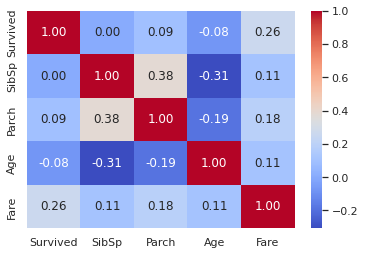

In [239]:
g=sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

- Fare만 관련있어보임
- feature에 대해 자세히 알아보자

- SibSp

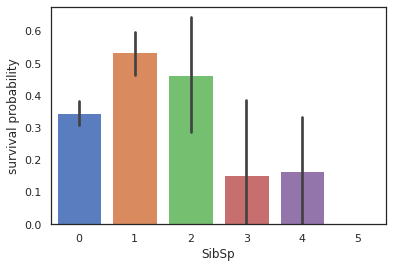

In [240]:
g = sns.barplot(x='SibSp',y="Survived",data=train, palette='muted')
g = g.set_ylabel('survival probability')


형제, 자매, 배우자가 많은 승객들은 생존률이 상대적으로 낮음

- Parch

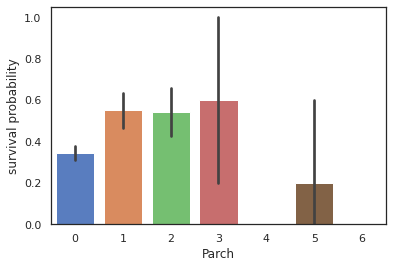

In [241]:
g = sns.barplot(x='Parch',y="Survived",data=train, palette='muted')
g = g.set_ylabel('survival probability')

- 5명 이상의 대가족은 독신/소규모 가족보다 생존률이 낮음
- 이때 3명의 아이/부모를 가진 경우 생존률이 가장 높은 것으로 보이지만 표준편차가 매우 높은 것을 주의

 - Age

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


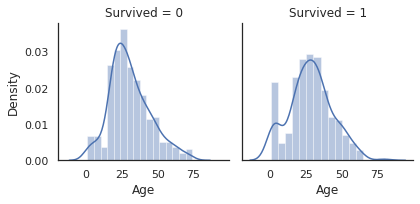

In [242]:
g=sns.FacetGrid(train, col='Survived')
g=g.map(sns.distplot, 'Age')

<ipython-input-243-e34ad01e26c1>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
<ipython-input-243-e34ad01e26c1>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)


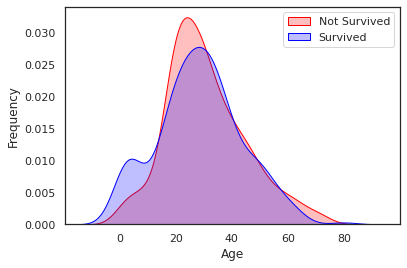

In [243]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

- Fare

In [244]:
dataset['Fare'].isnull().sum()

1

In [245]:
dataset['Fare']=dataset['Fare'].fillna(dataset['Fare'].median())

<ipython-input-246-7960836c9ba3>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))


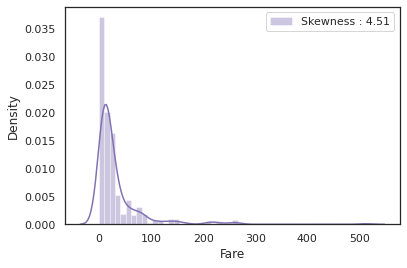

In [246]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

Fare 분포는 skewness가 매우 높으므로 log 변환을 해도 좋을 것

In [247]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

<ipython-input-248-35ec8efd2ddc>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))


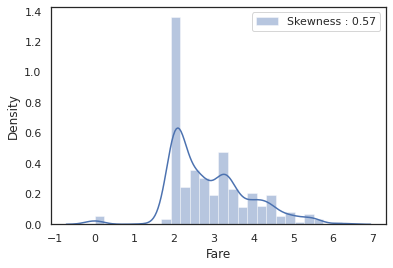

In [248]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

### 3.2 Categorical values

<br>

- Sex

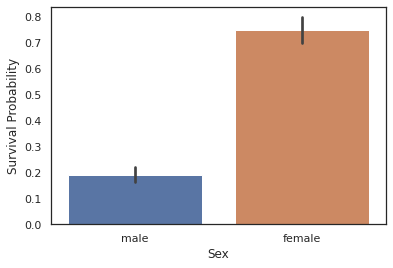

In [249]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [250]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


성별에 따른 생존률이 큰 차이를 보임

- Pclass

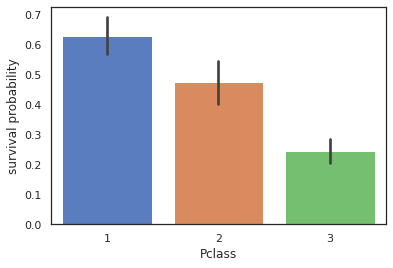

In [251]:
# Explore Pclass vs Survived
g = sns.barplot(x="Pclass",y="Survived",data=train, palette = "muted")
g = g.set_ylabel("survival probability")

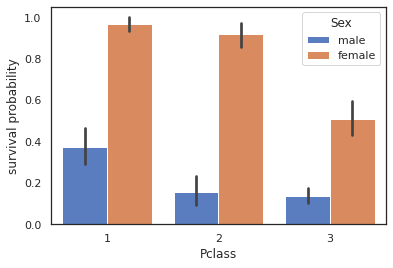

In [252]:
#성별로 한번 더 나눠서 시각화
g = sns.barplot(x="Pclass", y="Survived", hue="Sex", data=train, palette="muted")
g = g.set_ylabel("survival probability")

여성, 남성 두 성별 모두 First class의 승객이 생존률이 더 높음

- Embarked

In [253]:
dataset["Embarked"].isnull().sum()

2

가장 빈번한 값이 S이므로 missing value는 S로 대체

In [254]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

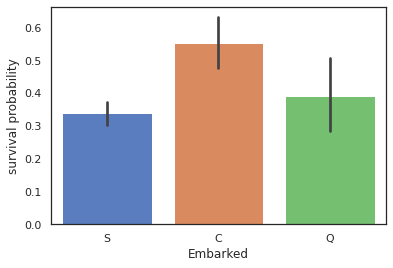

In [255]:
g = sns.barplot(x="Embarked", y="Survived",  data=train, palette="muted")
g = g.set_ylabel("survival probability")

- Cherbourg (C)
- Queenstown (Q)
- Southampton (S)

<br>

-  Pclass와 Embarked에 따른 생존률

<Axes: xlabel='Embarked', ylabel='count'>

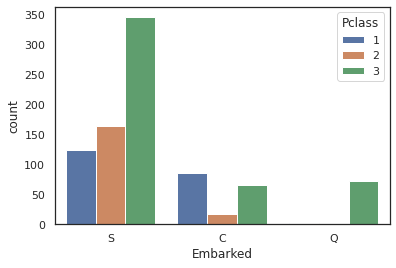

In [256]:
sns.countplot(x='Embarked', data=train, hue='Pclass')

## **4. Filling missing Values**

### 4.1 Age
- Age column contains 256 missing values in the whole dataset.

<Axes: xlabel='Sex', ylabel='Age'>

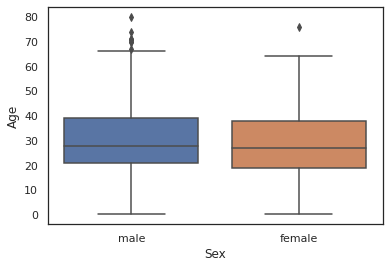

In [257]:
sns.boxplot(y="Age",x="Sex",data=dataset)

<Axes: xlabel='Sex', ylabel='Age'>

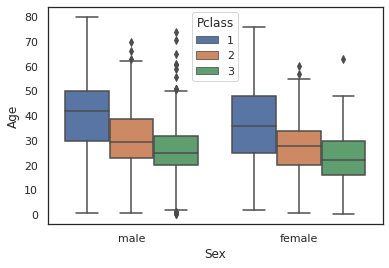

In [258]:
sns.boxplot(y="Age",x="Sex",hue="Pclass", data=dataset)

<Axes: xlabel='Parch', ylabel='Age'>

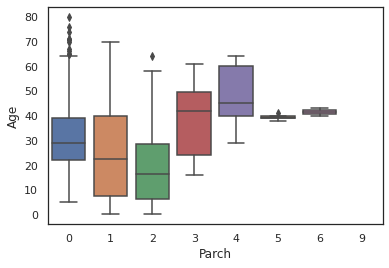

In [259]:
sns.boxplot(y="Age",x="Parch", data=dataset)

<Axes: xlabel='SibSp', ylabel='Age'>

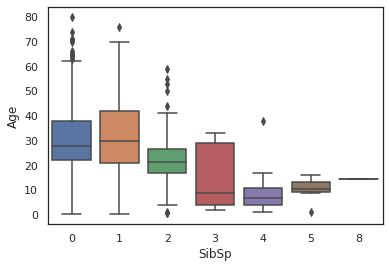

In [260]:
sns.boxplot(y="Age",x="SibSp", data=dataset)

Sex 변수를 인코딩
- male: 0
- female: 1

In [261]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

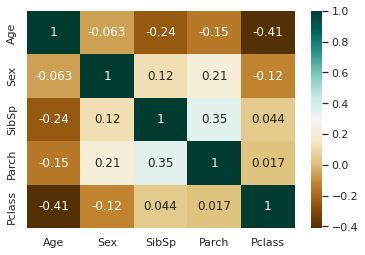

In [262]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

- Age의 missing value를 채우기 위해서 상관성이 높은 Parch, SibSP, Pclass를 사용
- 세개의 feature가 동일한 행이 있는 경우, 행들의 중앙값으로 대체
- 만약 세개의 feature가 동일한 행이 없는 경우, 나이 전체의 중앙값으로 대체

In [263]:
#아래 코드 경고 끄기
pd.set_option('mode.chained_assignment',  None)

In [264]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


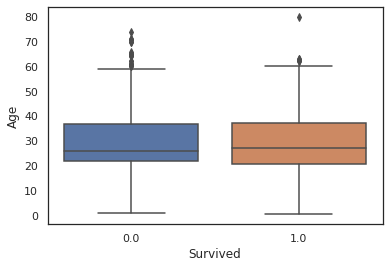

In [265]:
g = sns.boxplot(x="Survived", y = "Age",data = dataset)

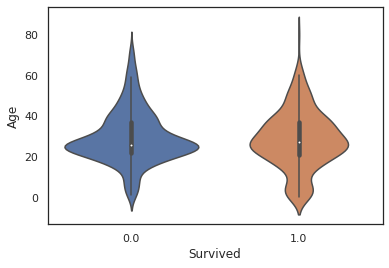

In [266]:
g = sns.violinplot(x="Survived", y = "Age",data = dataset)

##**5. Feature engineering**

###5.1 Name/Title

In [267]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

대피시 특별한 title을 가진 사람들이 선호될 수 있으므로 살펴보도록 하자

In [268]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

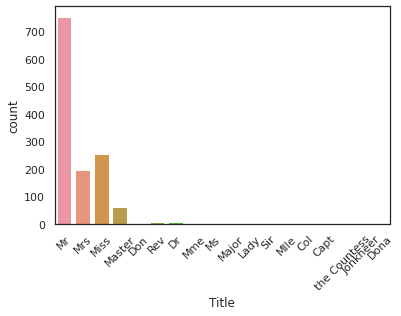

In [269]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

level을 4개로 축소
- Master
- Miss/Ms/Mme/Mlle/Mrs
- Mr
- Rare

In [270]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

[Text(0, 0, 'Master'),
 Text(1, 0, 'Miss/Ms/Mme/Mlle/Mrs'),
 Text(2, 0, 'Mr'),
 Text(3, 0, 'Rare')]

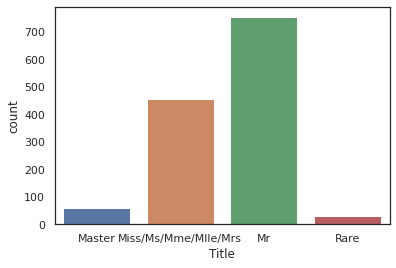

In [271]:
g = sns.countplot(x=dataset["Title"])
g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

title별 생존률 시각화

Text(0, 0.5, 'survival probability')

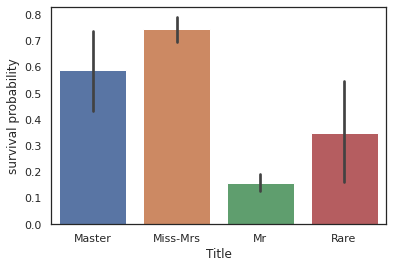

In [272]:
g = sns.barplot(x="Title",y="Survived",data=dataset)
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
plt.ylabel("survival probability")

Title column을 생성하여 사용하므로 Name은 삭제

In [273]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

###5.2 Family size
- 자기자신을 포함하여 family size feature를 추가
- SibSp + Parch + 1

In [274]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


Text(0, 0.5, 'Survival Probability')

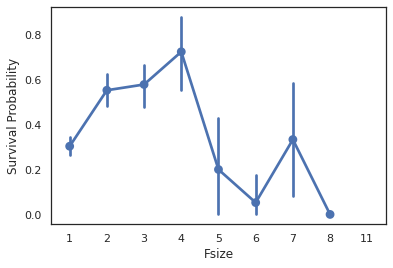

In [275]:
g = sns.pointplot(x="Fsize",y="Survived",data = dataset)
plt.ylabel("Survival Probability")

- family size가 중요한 역할을 하는 것처럼 보임
- family size를 4개의 범주형 column으로 생성

In [276]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

Text(0, 0.5, 'survival probability')

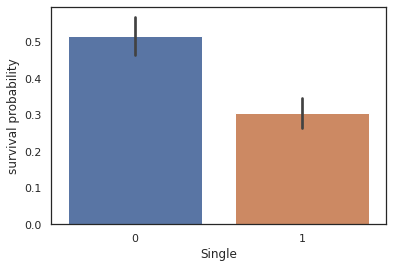

In [277]:
g = sns.barplot(x="Single",y="Survived",data=dataset)
plt.ylabel("survival probability")

Text(0, 0.5, 'survival probability')

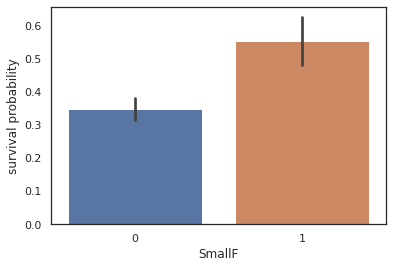

In [278]:
g = sns.barplot(x="SmallF",y="Survived",data=dataset)
plt.ylabel("survival probability")

Text(0, 0.5, 'survival probability')

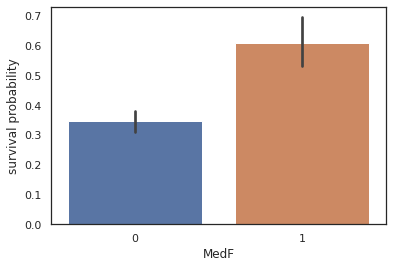

In [279]:
g = sns.barplot(x="MedF",y="Survived",data=dataset)
plt.ylabel("survival probability")

Text(0, 0.5, 'survival probability')

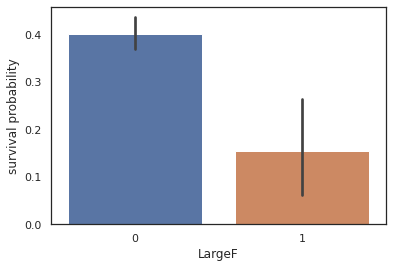

In [280]:
g = sns.barplot(x="LargeF",y="Survived",data=dataset)
plt.ylabel("survival probability")

In [281]:
#title, Emabrked 원-핫 인코딩
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")
#prefix: level 별로 만들어질 변수의 접두사

In [282]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


### 5.3 Cabin

In [283]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [284]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [285]:
dataset["Cabin"].isnull().sum()

1007

- 1007개 중에 292개만이 값이 존재
- missing value의 경우는 지정된 객실이 없는 경우라고 가정

In [286]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

- 객실 번호를 제외하고 객실의 알파벳만 사용
- 지정된 객실이 없는 경우는 X로 대체

In [287]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

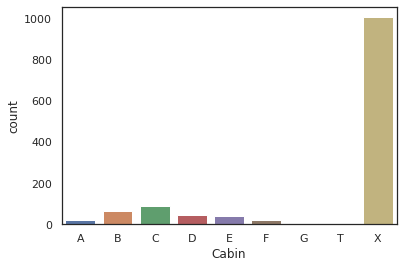

In [288]:
g = sns.countplot(x=dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

객실 별 생존률 시각화

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


Text(0, 0.5, 'Survival Probability')

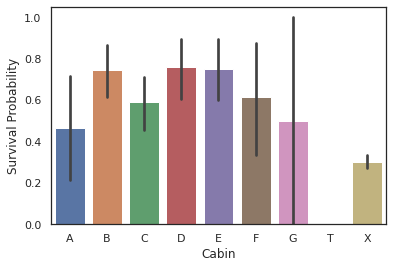

In [289]:
g = sns.barplot(y="Survived",x="Cabin",data=dataset,order=['A','B','C','D','E','F','G','T','X'])
plt.ylabel("Survival Probability")

Cabin column도 마찬가지로 원-핫 인코딩

In [290]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

###5.4 Ticket 

In [291]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- 동일한 접두사는 같은 객실 등급의 예약을 의미한다고 보고 접두사만 분리
- Cabin과 마찬가지로 접두사 없이 숫자만 적혀있는 경우는 X로 대체

In [292]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

Ticket과 Pcalss를 원-핫 인코딩

In [293]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [294]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

필요없는 변수 제거

In [295]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [296]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## **6. MODELING**

<br>

train과 test를 합쳐서 만들었던 dataset을 다시 분리

In [297]:
train=dataset[:train_len]
test=dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

target과 feature 분리

In [298]:
train['Survived']=train['Survived'].astype(int)

y_train=train['Survived']
X_train=train.drop(labels=['Survived'], axis=1)

### 6.1 Simple modeling

6.1.1 Cross validate models

In [299]:
kfold = StratifiedKFold(n_splits=10)

In [300]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [301]:
#model별 10번 반복한 평가 결과를 리스트 형태로 리스트에 저장
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

In [302]:
cv_results[0]

array([0.69662921, 0.70454545, 0.68181818, 0.80681818, 0.68181818,
       0.73863636, 0.71590909, 0.72727273, 0.79545455, 0.72727273])

리스트 안에는 kfold로 10번 평가한 점수가 들어있으므로 각 모델별로 score 평균과 표준편차를 구해 또 다른 리스트로 생성

In [303]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [305]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

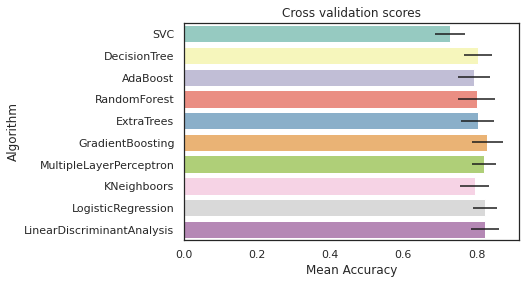

In [307]:
g = sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

#barplot() got multiple values for argument 'data'이라는 오류가 나오면 x와 y를 지정해주면 해결

###6.1.2 Hyperparameter tunning for best models

**GridSearchCV를 이용하여 best parameter 찾기**

- Adaboost

In [309]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


In [301]:
gsadaDTC.best_score_

- ExtraTrees

In [310]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.832035240040858

- RandomForestClassifier

In [312]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342824310520941

- Gradient boosting

In [313]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


0.8297497446373852

- SVC

In [314]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

###6.1.3 Plot learning curves

In [315]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

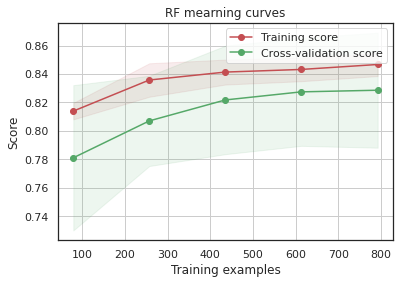

In [316]:
plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)

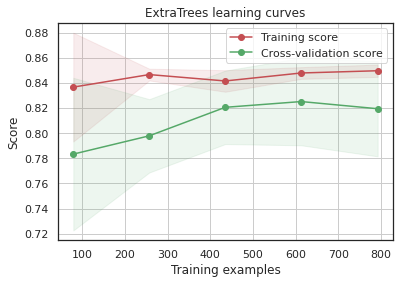

In [317]:
plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)

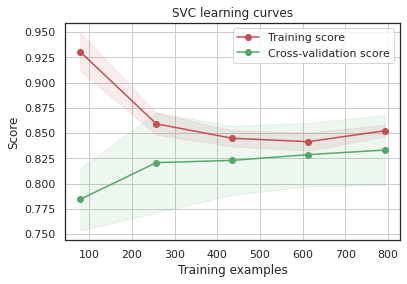

In [318]:
plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)

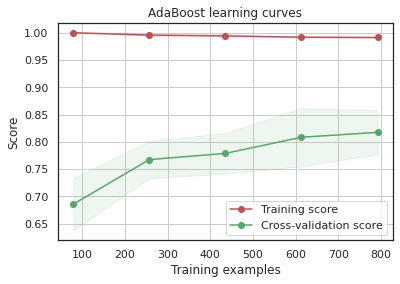

In [319]:
plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)

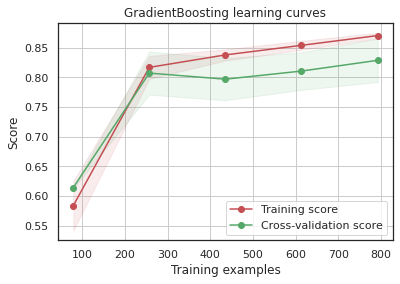

In [320]:
plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

### 6.1.4 Feature importance of tree based classifiers

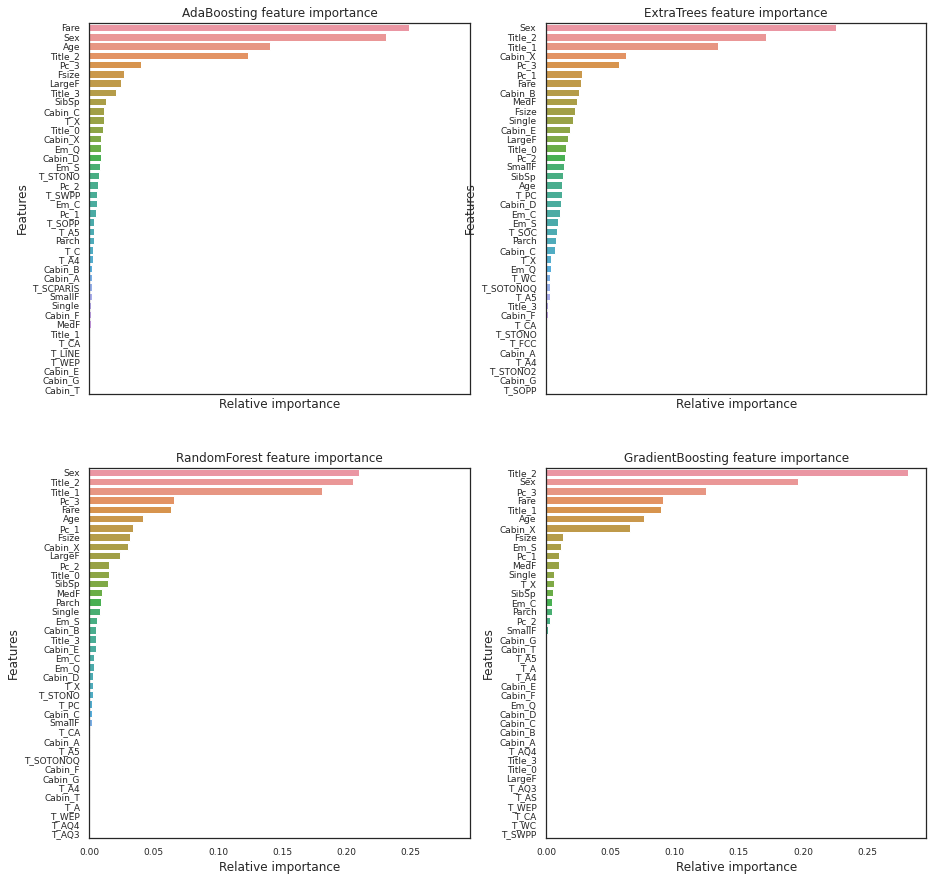

In [321]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

위 그래프를 살펴보면 Survived(target)은 Age, Sex, family size, the social standing(title)과 많이 관련된 것으로 볼 수 있음

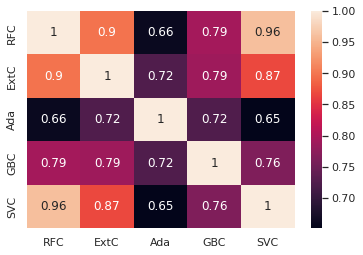

In [322]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

- 다섯개의 예측기가 차이는 있지만 유사한 결과를 내놓는 것으로 볼 수 있음
- 그러므로 ensemble mopdel을 고려해볼 수 있음

##**6.2 Ensemble modeling**

### 6.2.1 Combining models

- 5개의 분류기를 soft voting 방식으로 결합

In [323]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

## **6.3 Prediction**
###6.3.1 Predict and Submit results

In [324]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)